In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d mrinath/pneumonia

 99% 1.16G/1.17G [00:12<00:00, 117MB/s]
100% 1.17G/1.17G [00:12<00:00, 97.1MB/s]


In [4]:
import zipfile
zf = "/content/pneumonia.zip"
target_dir = "/content/dataset/cnn/pneumonia"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
train_path = '/content/dataset/cnn/pneumonia/folders/train'
test_path = '/content/dataset/cnn/pneumonia/folders/test'
valid_path = '/content/dataset/cnn/pneumonia/folders/valid'

In [7]:
batch_size = 19

img_height = 150
img_width = 150

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.4,shear_range=0.3,vertical_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [9]:
train = image_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',color_mode='grayscale',batch_size=batch_size)
test = test_data_gen.flow_from_directory(test_path,target_size=(img_height,img_width),shuffle=False,class_mode='binary',color_mode='grayscale',batch_size=batch_size)
valid = test_data_gen.flow_from_directory(valid_path,target_size=(img_height,img_width),class_mode='binary',color_mode='grayscale',batch_size=batch_size)

decoder_input = test_data_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',color_mode='grayscale',batch_size=batch_size,shuffle=False)
decoder_output = test_data_gen.flow_from_directory(train_path,target_size=(40,40),class_mode='binary',color_mode='grayscale',batch_size=batch_size,shuffle=False)

Found 4883 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 349 images belonging to 2 classes.
Found 4883 images belonging to 2 classes.
Found 4883 images belonging to 2 classes.


In [10]:
import tensorflow as tf

import os
import keras
from keras.models import Sequential, Model
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, BatchNormalization, Input, SeparableConv2D, UpSampling2D

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tqdm.notebook import tqdm

from keras.optimizers import SGD

In [11]:
#Creating the decoder's data
X = []
Y = []
for _ in tqdm(range(257)):
    X += list(decoder_input.next()[0])
    Y += list(decoder_output.next()[0])
X = np.array(X)
Y = np.array(Y)

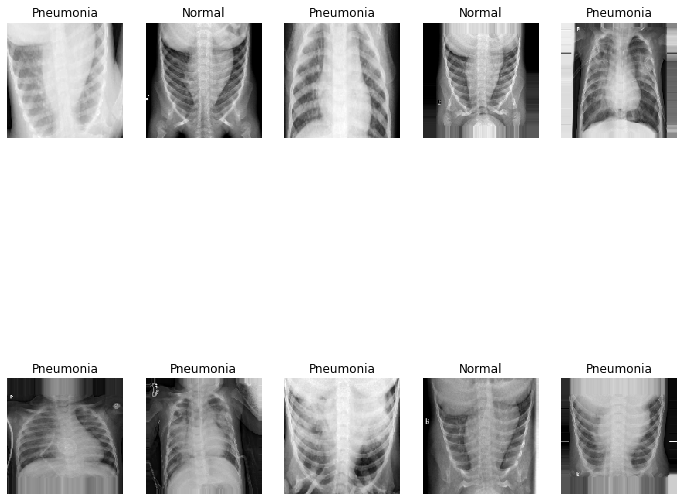

In [12]:
plt.figure(figsize=(12,12))
for i in range(0,10):
  plt.subplot(2,5,i+1)
  for X_batch,Y_batch in train:
    image = X_batch[0]
    dic = {0:'Normal',1:'Pneumonia'}
    plt.title(dic.get(Y_batch[0]))
    plt.axis('off')

    plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
    break

    plt.tight_layout()
    plt.show()

In [13]:
def SeparableConvBlock(filter_n,kernel_shape,pool_size,init,input_shape,name=None):
    
    input_layer = Input(input_shape)
    
    model = SeparableConv2D(filter_n,kernel_shape,input_shape=(img_width,img_height,1),kernel_initializer=init)(input_layer)
    model = BatchNormalization()(model)
    model = keras.layers.ELU()(model)

    model = SeparableConv2D(filter_n,kernel_shape,kernel_initializer=init)(model)
    model = BatchNormalization()(model)
    model = keras.layers.ELU()(model)


    model = MaxPooling2D(pool_size=pool_size)(model)
    
    return Model(input_layer,model,name=name),model.shape

In [14]:
input_layer = Input(shape=(img_height,img_width,1))

#Encoder

layer,shape = SeparableConvBlock(32,(3,3),(2,2),'glorot_uniform',(img_width,img_height,1),"SPB1")
enc = layer(input_layer)
layer,shape = SeparableConvBlock(64,(3,3),(2,2),'glorot_uniform',(shape[1:]),"SPB2")
enc = layer(enc)
layer,shape = SeparableConvBlock(128,(3,3),(2,2),'glorot_uniform',(shape[1:]),"SPB3")
enc = layer(enc)
layer,shape = SeparableConvBlock(256,(3,3),(2,2),'glorot_uniform',(shape[1:]),"SPB4")
enc = layer(enc)

Encoder = Model(input_layer,enc)

#Decoder

# decoder = SeparableConv2D(128, (3, 3), activation='sigmoid', padding='same')(enc)
# decoder = BatchNormalization()(decoder)
# decoder = SeparableConv2D(128, (3, 3), activation='sigmoid', padding='same')(decoder)
# decoder = BatchNormalization()(decoder)
# decoder = UpSampling2D((2,2))(decoder)

# decoder = SeparableConv2D(64, (3, 3), activation='sigmoid', padding='same')(decoder)
# decoder = BatchNormalization()(decoder)
# decoder = SeparableConv2D(64, (3, 3), activation='sigmoid', padding='same')(decoder)
# decoder = BatchNormalization()(decoder)
# decoder = UpSampling2D((2,2))(decoder)

# decoder = SeparableConv2D(32, (3, 3), activation='sigmoid', padding='same')(decoder)
# decoder = BatchNormalization()(decoder)
# decoder = SeparableConv2D(32, (3, 3), activation='sigmoid', padding='same')(decoder)
# decoder = BatchNormalization()(decoder)
# decoder = UpSampling2D((2,2))(decoder)


# decoder = SeparableConv2D(1, (3, 3), activation='sigmoid', padding='same')(decoder)

# Decoder = Model(input_layer,decoder)
                
                
#Classifier
flatten = Flatten()(enc)
dense = Dense(128,activation='relu')(flatten)
dense = BatchNormalization()(dense)
dense = Dense(64,activation='relu')(dense)
dense = BatchNormalization()(dense)
dense = Dropout(0.5)(dense)
dense = Dense(1,activation='sigmoid')(dense)

Classifier = Model(input_layer,dense)

In [ ]:
Decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
SPB1 (Functional)            (None, 73, 73, 32)        1673      
_________________________________________________________________
SPB2 (Functional)            (None, 34, 34, 64)        7648      
_________________________________________________________________
SPB3 (Functional)            (None, 15, 15, 128)       27584     
_________________________________________________________________
SPB4 (Functional)            (None, 5, 5, 256)         104320    
_________________________________________________________________
separable_conv2d_8 (Separabl (None, 5, 5, 128)         35200     
_________________________________________________________________
batch_normalization_8 (Batch (None, 5, 5, 128)         512 

In [ ]:
Decoder.compile(loss='mean_squared_error', optimizer = SGD())

In [ ]:
Decoder.fit(X,Y,batch_size=batch_size,epochs=30)

Epoch 1/30
257/257 [==============================] - 74s 165ms/step - loss: 0.0423
Epoch 2/30
257/257 [==============================] - 43s 166ms/step - loss: 0.0265
Epoch 3/30
257/257 [==============================] - 43s 166ms/step - loss: 0.0223
Epoch 4/30
257/257 [==============================] - 43s 166ms/step - loss: 0.0201
Epoch 5/30
257/257 [==============================] - 43s 166ms/step - loss: 0.0189
Epoch 6/30
257/257 [==============================] - 43s 167ms/step - loss: 0.0177
Epoch 7/30
257/257 [==============================] - 43s 166ms/step - loss: 0.0172
Epoch 8/30
257/257 [==============================] - 43s 166ms/step - loss: 0.0166
Epoch 9/30
257/257 [==============================] - 43s 167ms/step - loss: 0.0162
Epoch 10/30
257/257 [==============================] - 43s 166ms/step - loss: 0.0160
Epoch 11/30
257/257 [==============================] - 43s 166ms/step - loss: 0.0155
Epoch 12/30
257/257 [==============================] - 43s 167ms/step - lo

In [ ]:
predictions = Decoder.predict(X)

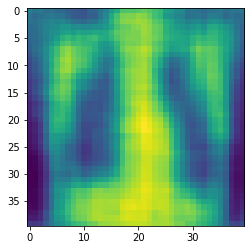

In [ ]:
plt.imshow((tf.squeeze(predictions[0])))
plt.show()

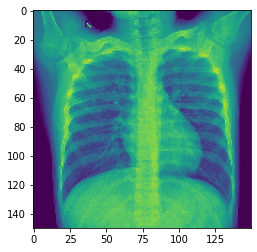

In [ ]:
plt.imshow((tf.squeeze(X[0])))
plt.show()

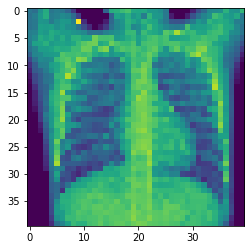

In [ ]:
plt.imshow((tf.squeeze(Y[0])))
plt.show()

In [15]:
Classifier.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
SPB1 (Functional)            (None, 73, 73, 32)        1673      
_________________________________________________________________
SPB2 (Functional)            (None, 34, 34, 64)        7648      
_________________________________________________________________
SPB3 (Functional)            (None, 15, 15, 128)       27584     
_________________________________________________________________
SPB4 (Functional)            (None, 5, 5, 256)         104320    
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               8193

In [16]:
Classifier.compile(optimizer=SGD(),loss='binary_crossentropy',metrics=['accuracy'])

In [17]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes),train.classes)
cw = dict(zip(np.unique(train.classes),weights))
print(cw)

{0: 2.0761054421768708, 1: 0.6586188292419747}


In [18]:
Classifier.fit(train,epochs=25,validation_data=valid,class_weight=cw,batch_size=512)

Epoch 1/25
257/257 [==============================] - 92s 227ms/step - loss: 0.5671 - accuracy: 0.7010 - val_loss: 0.9629 - val_accuracy: 0.5043
Epoch 2/25
257/257 [==============================] - 58s 224ms/step - loss: 0.3971 - accuracy: 0.8041 - val_loss: 1.7079 - val_accuracy: 0.5043
Epoch 3/25
257/257 [==============================] - 58s 225ms/step - loss: 0.3500 - accuracy: 0.8457 - val_loss: 0.2527 - val_accuracy: 0.9083
Epoch 4/25
257/257 [==============================] - 57s 223ms/step - loss: 0.3094 - accuracy: 0.8617 - val_loss: 0.7895 - val_accuracy: 0.6791
Epoch 5/25
257/257 [==============================] - 58s 223ms/step - loss: 0.2748 - accuracy: 0.8824 - val_loss: 0.3238 - val_accuracy: 0.8883
Epoch 6/25
257/257 [==============================] - 58s 224ms/step - loss: 0.2602 - accuracy: 0.8916 - val_loss: 0.4639 - val_accuracy: 0.8109
Epoch 7/25
257/257 [==============================] - 57s 223ms/step - loss: 0.2691 - accuracy: 0.8935 - val_loss: 0.6007 - val_ac

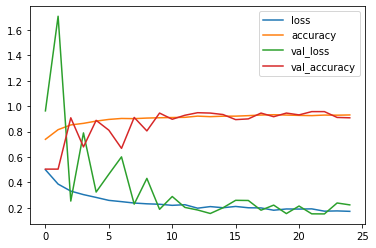

In [19]:
pd.DataFrame(Classifier.history.history).plot()

In [20]:
test_accu = Classifier.evaluate(test)
print('The testing accuracy is - ',test_accu[1]*100,'%')

33/33 [==============================] - 5s 155ms/step - loss: 0.1461 - accuracy: 0.9519
The testing accuracy is -  95.19230723381042 %


In [21]:
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score, log_loss

In [22]:
y_bar = np.round(Classifier.predict(test)).reshape(-1)
y_act = test.labels

In [23]:
##accuracy
print("Accuracy: ",accuracy_score(y_bar,y_act))
##Roc_Auc Score
print("ROC-AUC score: ",roc_auc_score(y_bar,y_act))
##F1-Score Score
print("F1 score: ",f1_score(y_bar,y_act))
##Log Loss Score
print("Log Loss: ",log_loss(y_bar,y_act))

Accuracy:  0.9519230769230769
ROC-AUC score:  0.9474463360473723
F1 score:  0.961340206185567
Log Loss:  1.6605398798135163


In [ ]:
Classifier.save('custom_cnn.h5')